## Code Setup

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import math
from functools import partial

import numpy as np
from xgboost import XGBClassifier, XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.base import clone, BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy
import tensorflow.keras.backend as K
from tensorflow.keras import callbacks, layers, wrappers, models, constraints, optimizers
import tensorflow as tf
from category_encoders import OrdinalEncoder

from augury import model_tracking
from augury.ml_data import MLData
from augury.ml_estimators import StackingEstimator, ConfidenceEstimator
from augury.ml_estimators.stacking_estimator import ML_PIPELINE
from augury.sklearn import (
    TeammatchToMatchConverter,
    EloRegressor,
    bits_scorer,
    _calculate_bits,
    TimeSeriesRegressor,
    ColumnDropper,
    CorrelationSelector,
)
from augury.settings import SEED, CV_YEAR_RANGE, TRAIN_YEAR_RANGE, CATEGORY_COLS, TEAM_NAMES, ROUND_TYPES, VENUES


np.random.seed(SEED)

In [3]:
data = MLData()
data.data

2020-01-17 11:33:07,510 - kedro.io.data_catalog - INFO - Loading data from `model_data` (JSONLocalDataSet)...


team   oppo_team round_type  \
Adelaide         1991 1           Adelaide    Hawthorn    Regular   
                      2           Adelaide     Carlton    Regular   
                      3           Adelaide      Sydney    Regular   
                      4           Adelaide    Essendon    Regular   
                      5           Adelaide  West Coast    Regular   
...                                    ...         ...        ...   
Western Bulldogs 2019 20  Western Bulldogs    Brisbane    Regular   
                      21  Western Bulldogs    Essendon    Regular   
                      22  Western Bulldogs         GWS    Regular   
                      23  Western Bulldogs    Adelaide    Regular   
                      24  Western Bulldogs         GWS     Finals   

                                      venue prev_match_oppo_team  \
Adelaide         1991 1       Football Park                    0   
                      2       Football Park             Hawthorn   
                      3              S.C.G.              Carlton   
                      4          Windy Hill               Sydney   
                      5             Subiaco             Essendon   
...                                     ...                  ...   
Western Bulldogs 2019 20              Gabba            Fremantle   
                      21          Docklands             Brisbane   
                      22  Sydney Showground             Essendon   
                      23     Eureka Stadium                  GWS   
                      24  Sydney Showground             Adelaide   

                         oppo_prev_match_oppo_team                      date  \
Adelaide         1991 1                  Melbourne 1991-03-22 03:56:00+00:00   
                      2                    Fitzroy 1991-03-31 03:56:00+00:00   
                      3                   Hawthorn 1991-04-07 03:05:00+00:00   
                      4            North Melbourne 1991-04-13 03:30:00+00:00   
                      5            North Melbourne 1991-04-21 05:27:00+00:00   
...                                            ...                       ...   
Western Bulldogs 2019 20                  Hawthorn 2019-08-04 02:58:00+00:00   
                      21             Port Adelaide 2019-08-10 03:30:00+00:00   
                      22                  Hawthorn 2019-08-18 03:05:00+00:00   
                      23               Collingwood 2019-08-25 03:30:00+00:00   
                      24                Gold Coast 2019-09-07 03:05:00+00:00   

                          team_goals  team_behinds  score  ...  \
Adelaide         1991 1           24            11    155  ...   
                      2           12             9     81  ...   
                      3           19            18    132  ...   
                      4            6            11     47  ...   
                      5            9            11     65  ...   
...                              ...           ...    ...  ...   
Western Bulldogs 2019 20          11            14     80  ...   
                      21          21            11    137  ...   
                      22          19            12    126  ...   
                      23          18            13    121  ...   
                      24           8             7     55  ...   

                          oppo_rolling_prev_match_goals_divided_by_rolling_prev_match_goals_plus_rolling_prev_match_behinds  \
Adelaide         1991 1                                                 0.0                                                   
                      2                                                 0.0                                                   
                      3                                                 0.0                                                   
                      4                                                 0.0                                                   
   

In [4]:
se = StackingEstimator()
se.fit(*data.train_data)

2020-01-17 11:33:21,736 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


StackingEstimator(min_year=1965, name='stacking_estimator',
                  pipeline=StackingRegressor(meta_regressor=Pipeline(memory=None,
                                                                     steps=[('standardscaler',
                                                                             StandardScaler(copy=True,
                                                                                            with_mean=True,
                                                                                            with_std=True)),
                                                                            ('extratreesregressor',
                                                                             ExtraTreesRegressor(bootstrap=False,
                                                                                                 ccp_alpha=0.0,
                                                                                                 criterion='mse',
   

## ELO

In [5]:
elo = ConfidenceEstimator()

data.train_year_range = TRAIN_YEAR_RANGE
elo.fit(*data.train_data)

ConfidenceEstimator(name='confidence_estimator',
                    pipeline=Pipeline(memory=None,
                                      steps=[('teammatchtomatchconverter',
                                              TeammatchToMatchConverter(match_cols=['date',
                                                                                    'venue',
                                                                                    'round_type'])),
                                             ('eloregressor',
                                              EloRegressor(home_ground_advantage=9,
                                                           k=35.6, m=130, s=250,
                                                           season_carryover=0.575,
                                                           x=0.49))],
                                      verbose=False))

In [6]:
bits = bits_scorer(elo, *data.test_data)
bits

13.280320786654055

## Time-series model

In [7]:
# Based on StackingEstimator predictions

tsr = TimeSeriesRegressor(sm.tsa.ARIMA, order=(6, 0, 1), confidence=True)

data.train_year_range = TRAIN_YEAR_RANGE
X_train, y_train = data.train_data
X_train_filt = X_train.query('year >= @se.min_year')

X_train_ts = pd.DataFrame(
    {
        'pred_margin': se.predict(X_train),
        'date': X_train_filt['date'],
        'team': X_train_filt['team'],
    },
    index=X_train_filt.index,
)

tsr.fit(X_train_ts, y_train)

TimeSeriesRegressor(confidence=True, exog_cols=[], order=(6, 0, 1),
                    stats_model=<class 'statsmodels.tsa.arima_model.ARIMA'>)

In [8]:
bits = bits_scorer(tsr, *data.test_data)
bits

-1.3526412966339958

In [9]:
# Based on raw time-series data

tsr = TimeSeriesRegressor(
    sm.tsa.ARIMA, order=(6, 0, 1), exog_cols=["at_home", "oppo_cum_percent"], confidence=True
)
tsr.fit(*data.train_data)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


TimeSeriesRegressor(confidence=True, exog_cols=['at_home', 'oppo_cum_percent'],
                    order=(6, 0, 1),
                    stats_model=<class 'statsmodels.tsa.arima_model.ARIMA'>)

In [10]:
bits = bits_scorer(tsr, *data.test_data)
bits

-1.9456151833768789

## ML algorithms

### Code setup

In [5]:
# train/validation/test data for models that use full data set
data.train_year_range = TRAIN_YEAR_RANGE
X_train, _y_train = data.train_data
# Arbitrarily making draws losses, because why not
y_train = (_y_train > 0).astype(int)

_X_test, _y_test = data.test_data
test_years = _X_test['year'].drop_duplicates().sort_values()

# Separating the two default test years into validation & test sets,
# so we can use the validation set for early stopping during XGB training
X_val = _X_test.query('year < @test_years.iloc[-1]')
X_test = _X_test.query('year == @test_years.iloc[-1]')

y_win = (_y_test > 0).astype(int)
y_val = y_win.loc[(slice(None), test_years.iloc[:-1], slice(None))]
y_test = y_win.loc[(slice(None), test_years.iloc[-1:], slice(None))]


# train/validation/test data for models based on main model's predictions
X_train_se = se.predict(data.train_data[0]).reshape(-1, 1)
y_train_se = y_train.loc[(slice(None), slice(1965, None), slice(None))]
X_pred = pd.DataFrame(se.predict(data.test_data[0]), columns=['pred_margin'], index=data.test_data[0].index)
X_val_se = X_pred.loc[(slice(None), test_years.iloc[:-1], slice(None)), :]

X_test_se = X_pred.loc[(slice(None), test_years.iloc[-1:], slice(None)), :]

#### Base bits calculation

In [6]:
LOG_BASE = 2
# For regressors that might try to predict negative values or 0,
# we need a slightly positive minimum to not get errors when calculating
# logarithms
MIN_VAL = 1 * 10 ** -10


def _positive_pred(y_pred):
    min_array = np.repeat(MIN_VAL, len(y_pred))
    return np.where(y_pred <= 0, min_array, y_pred)


def _draw_bits(y_pred, y_true):
    return 1 + (0.5 * np.log2(_positive_pred(y_pred * (1 - y_pred))))

def _win_bits(y_pred, y_true):
    return 1 + np.log2(_positive_pred(y_pred))

def _loss_bits(y_pred, y_true):
    return 1 + np.log2(_positive_pred(1 - y_pred))

# Raw bits calculations per http://probabilistic-footy.monash.edu/~footy/about.shtml
def calculate_bits(y_pred, y_true):
    return np.where(
        y_true == 0.5,
        _draw_bits(y_pred, y_true),
        np.where(
            y_true == 1.0,
            _win_bits(y_pred, y_true),
            _loss_bits(y_pred, y_true)
        )
    )


def bits_error(y_pred, y_true):
    # We adjust bits calculation to make a valid ML error formula such that 0 represents a correct prediction,
    # and the further off the prediction the higher the error value.
    return np.where(
        y_true == 0.5,
        -1 * _draw_bits(y_pred, y_true),
        np.where(
            y_true == 1.0,
            1 - _win_bits(y_pred, y_true),
            1 + (-1 * _loss_bits(y_pred, y_true)),
        ),
    )

### XGBoost

#### Code setup

In [7]:
def _draw_bits_gradient(y_pred, y_true):
    return (y_pred - 0.5) / (math.log(2) * (y_pred - y_pred**2))

def _win_bits_gradient(y_pred, y_true):
    return -1 / (math.log(2) * y_pred)

def _loss_bits_gradient(y_pred, y_true):
    return 1 / (math.log(2) * (1 - y_pred))

def _bits_gradient(y_pred, y_true):
    return np.where(
        y_true == 0.5,
        _draw_bits_gradient(y_pred, y_true),
        np.where(
            y_true == 1.0,
            _win_bits_gradient(y_pred, y_true),
            _loss_bits_gradient(y_pred, y_true),
        ),
    )


def _draw_bits_hessian(y_pred, y_true):
    return (y_pred**2 - y_pred + 0.5) / (math.log(2) * y_pred**2 * (y_pred - 1)**2)

def _win_bits_hessian(y_pred, y_true):
    return 1 / (math.log(2) * y_pred**2)

def _loss_bits_hessian(y_pred, y_true):
    return 1 / (math.log(2) * (1 - y_pred)**2)

def _bits_hessian(y_pred, y_true):
    return np.where(
        y_true == 0.5,
        _draw_bits_hessian(y_pred, y_true),
        np.where(
            y_true == 1.0,
            _win_bits_hessian(y_pred, y_true),
            _loss_bits_hessian(y_pred, y_true),
        ),
    )


# Per documentation, follows typical Scikit-learn order (true, pred), but rest of XGB callbacks
# keep XGB default order (pred, true), so all other functions follow the latter convention
# to minimise inconsistency
def bits_objective(y_true, y_pred):
    return _bits_gradient(y_pred, y_true), _bits_hessian(y_pred, y_true)


def bits_metric(y_pred, y_true_matrix):
    y_true = y_true_matrix.get_label()

    return 'mean_bits_error', bits_error(y_pred, y_true).mean()

In [14]:
bits_df = (
    pd
    .DataFrame(
        np.vstack((np.repeat([0, 0.5, 1], 100), np.random.uniform(low=0.0, high=1.0, size=300))).T,
        columns=['result', 'conf_win']
    )
    .astype({'result': 'category'})
    .assign(
        bits=lambda df: calculate_bits(df['conf_win'], df['result']),
        bits_error=lambda df: bits_error(df['conf_win'], df['result']),
        bits_grad=lambda df: _bits_gradient(df['conf_win'], df['result']),
        bits_hess=lambda df: _bits_hessian(df['conf_win'], df['result']),
        result_label=lambda df: df['result'].astype(str).map({'1.0': 'win', '0.0': 'loss', '0.5': 'draw'}),
    ).melt(
        id_vars=['result_label', 'conf_win'],
        value_vars=['bits', 'bits_error', 'bits_grad', 'bits_hess'],
        var_name='bits_metric',
    )
)


bits_df

,result_label,conf_win,bits_metric,value
0,loss,0.374540,bits,0.322989
1,loss,0.950714,bits,-3.342687
2,loss,0.731994,bits,-0.899662
3,loss,0.598658,bits,-0.317098
4,loss,0.156019,bits,0.755283
...,...,...,...,...
1195,win,0.522243,bits_hess,5.289673
1196,win,0.769994,bits_hess,2.433326
1197,win,0.215821,bits_hess,30.973268
1198,win,0.622890,bits_hess,3.718358


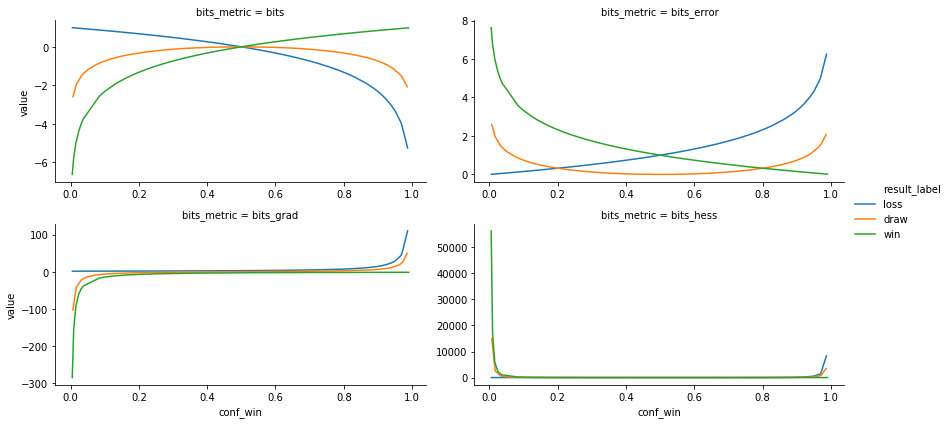

In [15]:
sns.relplot(
    data=bits_df,
    x='conf_win',
    y='value',
    col="bits_metric",
    col_wrap=2,
    hue='result_label',
    kind='line',
    height=3,
    aspect=2,
    facet_kws={'sharey': False, 'sharex': False},
)

#### XGBClassifier

In [16]:
# Baseline without custom objective or metric

xgbc = clone(ML_PIPELINE)
# We don't need the DataFrameConverter
xgbc.steps = xgbc.steps[1:]
xgbc.steps[-1] = ('xgbclassifier', XGBClassifier(random_state=SEED),)

xgbc.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columndropper',
                 ColumnDropper(cols_to_drop=['prev_match_oppo_team',
                                             'oppo_prev_match_oppo_team',
                                             'prev_match_at_home',
                                             'oppo_prev_match_at_home',
                                             'date'])),
                ('correlationselector',
                 CorrelationSelector(cols_to_keep=['team', 'oppo_team',
                                                   'round_type', 'venue'],
                                     labels=Adelaide          1991  1     86
                        2    -23
                        3     24
                        4    -45
                        5    -65
                              ..
Western Bulldogs  2016  23   -20
                        24    47
                        25    23...
                 XGBClassifier(base_score=0.5, booster='gbtree',
          

In [17]:
bits = bits_scorer(xgbc, X_test, y_test, proba=True)
bits

43.65319192687128

In [280]:
# XGB with custom objective and metric

X_val_trans = xgbc[:-1].transform(X_val)

xgbc.set_params(xgbclassifier__objective=bits_objective)
xgbc.fit(
    X_train,
    y_train,
    xgbclassifier__eval_metric=bits_metric,
    xgbclassifier__eval_set=[(X_val_trans, y_val)],
    xgbclassifier__early_stopping_rounds=5,
)

[0]	validation_0-error:0.371981	validation_0-mean_bits_error:0.996387
Multiple eval metrics have been passed: 'validation_0-mean_bits_error' will be used for early stopping.

Will train until validation_0-mean_bits_error hasn't improved in 5 rounds.
[1]	validation_0-error:0.355072	validation_0-mean_bits_error:0.992562
[2]	validation_0-error:0.364734	validation_0-mean_bits_error:0.988947
[3]	validation_0-error:0.352657	validation_0-mean_bits_error:0.985593
[4]	validation_0-error:0.357488	validation_0-mean_bits_error:0.981866
[5]	validation_0-error:0.347826	validation_0-mean_bits_error:0.978469
[6]	validation_0-error:0.355072	validation_0-mean_bits_error:0.97544
[7]	validation_0-error:0.342995	validation_0-mean_bits_error:0.972262
[8]	validation_0-error:0.352657	validation_0-mean_bits_error:0.969467
[9]	validation_0-error:0.342995	validation_0-mean_bits_error:0.96623
[10]	validation_0-error:0.347826	validation_0-mean_bits_error:0.96333
[11]	validation_0-error:0.342995	validation_0-mean_b

Pipeline(memory=None,
         steps=[('columndropper',
                 ColumnDropper(cols_to_drop=['prev_match_oppo_team',
                                             'oppo_prev_match_oppo_team',
                                             'prev_match_at_home',
                                             'oppo_prev_match_at_home',
                                             'date'])),
                ('correlationselector',
                 CorrelationSelector(cols_to_keep=['team', 'oppo_team',
                                                   'round_type', 'venue'],
                                     labels=Adelaide          1991  1     86
                        2    -23
                        3     24
                        4    -45
                        5    -65
                              ..
Western Bulldogs  2016  23   -20
                        24    47
                        25    23...
                 XGBClassifier(base_score=0.5, booster='gbtree',
          

In [284]:
bits = bits_scorer(xgbc, X_test, y_test, proba=True)
bits

41.478286238536334

In [20]:
# XGB with custom objective and metric, based on StackingEstimator predictions

xgb = make_pipeline(StandardScaler(), XGBClassifier(random_state=SEED, objective=bits_objective))

X_val_trans = xgb[:-1].fit_transform(X_val_se)

xgb.fit(
    X_train_se,
    y_train_se,
    xgbclassifier__eval_metric=bits_metric,
    xgbclassifier__eval_set=[(X_val_trans, y_val)],
    xgbclassifier__early_stopping_rounds=5,
)

[0]	validation_0-error:0.309179	validation_0-mean_bits_error:0.986686
Multiple eval metrics have been passed: 'validation_0-mean_bits_error' will be used for early stopping.

Will train until validation_0-mean_bits_error hasn't improved in 5 rounds.
[1]	validation_0-error:0.309179	validation_0-mean_bits_error:0.973975
[2]	validation_0-error:0.309179	validation_0-mean_bits_error:0.961926
[3]	validation_0-error:0.309179	validation_0-mean_bits_error:0.950604
[4]	validation_0-error:0.309179	validation_0-mean_bits_error:0.940074
[5]	validation_0-error:0.309179	validation_0-mean_bits_error:0.930404
[6]	validation_0-error:0.309179	validation_0-mean_bits_error:0.921662
[7]	validation_0-error:0.309179	validation_0-mean_bits_error:0.913918
[8]	validation_0-error:0.309179	validation_0-mean_bits_error:0.907243
[9]	validation_0-error:0.309179	validation_0-mean_bits_error:0.901705
[10]	validation_0-error:0.309179	validation_0-mean_bits_error:0.897375
[11]	validation_0-error:0.309179	validation_0-mea

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [21]:
bits = bits_scorer(
    xgb,
    X_test_se,
    y_test,
    proba=True,
    # Temporarily adding info_df to allow reshaping of X even when it doesn't have
    # the usual categorical columns
    info_df=data.test_data[0].loc[
        (slice(None), test_years.iloc[-1], slice(None)),
        ['team', 'oppo_team', 'year', 'round_number', 'at_home']
    ],
)
bits

33.57497090471635

#### XGBRegressor

In [22]:
# Baseline without custom objective or metric

xgbr = clone(ML_PIPELINE)
# We don't need the DataFrameConverter for this
xgbr.steps = xgbr.steps[1:]
xgbr.steps[-1] = ('xgbregressor', XGBRegressor(random_state=SEED, objective='reg:squarederror'))

xgbr.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Pipeline(memory=None,
         steps=[('columndropper',
                 ColumnDropper(cols_to_drop=['prev_match_oppo_team',
                                             'oppo_prev_match_oppo_team',
                                             'prev_match_at_home',
                                             'oppo_prev_match_at_home',
                                             'date'])),
                ('correlationselector',
                 CorrelationSelector(cols_to_keep=['team', 'oppo_team',
                                                   'round_type', 'venue'],
                                     labels=Adelaide          1991  1     86
                        2    -23
                        3     24
                        4    -45
                        5    -65
                              ..
Western Bulldogs  2016  23   -20
                        24    47
                        25    23...
                              colsample_bylevel=1, colsample_bynode=1,
    

In [23]:
bits = bits_scorer(xgbr, X_test, y_test)
bits

12.701972067459021

In [24]:
# XGB with custom objective & metric

X_val_trans = xgbr[:-1].transform(X_val)

xgbr.set_params(xgbregressor__objective=bits_objective)

xgbr.fit(
    X_train,
    y_train,
    xgbregressor__eval_metric=bits_metric,
    xgbregressor__eval_set=[(X_val_trans, y_val)],
    xgbregressor__early_stopping_rounds=5,
)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:04:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.4952	validation_0-mean_bits_error:0.986207
Multiple eval metrics have been passed: 'validation_0-mean_bits_error' will be used for early stopping.

Will train until validation_0-mean_bits_error hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.490751	validation_0-mean_bits_error:0.973495
[2]	validation_0-rmse:0.486262	validation_0-mean_bits_error:0.960707
[3]	validation_0-rmse:0.482431	validation_0-mean_bits_error:0.949786
[4]	validation_0-rmse:0.478192	validation_0-mean_bits_error:0.937672
[5]	validation_0-rmse:0.475517	validation_0-mean_bits_error:0.929884
[6]	validation_0-rmse:0.472348	validation_0-mean_bits_error:0.920573
[7]	validation_0-rmse:0.469932	validation_0-mean_bits_error:0.913343
[8]	validation_0-rmse:0.467152	validation_0-mean_bits_error:0.904997
[9]	validation_0-rmse:0.466232	validation_0-mean_bits_error:0.901929
[10]	

Pipeline(memory=None,
         steps=[('columndropper',
                 ColumnDropper(cols_to_drop=['prev_match_oppo_team',
                                             'oppo_prev_match_oppo_team',
                                             'prev_match_at_home',
                                             'oppo_prev_match_at_home',
                                             'date'])),
                ('correlationselector',
                 CorrelationSelector(cols_to_keep=['team', 'oppo_team',
                                                   'round_type', 'venue'],
                                     labels=Adelaide          1991  1     86
                        2    -23
                        3     24
                        4    -45
                        5    -65
                              ..
Western Bulldogs  2016  23   -20
                        24    47
                        25    23...
                              colsample_bylevel=1, colsample_bynode=1,
    

In [25]:
bits = bits_scorer(xgbr, X_test, y_test)
bits

32.145051482555104

#### Conclusion

`XGBClassifier` without custom loss/metric for bits performs slightly better than the classifier that uses the bits loss/metric, but I imaginge some tuning would make the custom-loss model better since the defaults are set to work well together out-of-the-box. Regardless, the classifier performs noticeably better than `XGBRegressor`.

### Keras

#### Code setup

In [7]:
# Basic NN architecture copied from notebook 6.2-all-data-nn

# For regressors that might try to predict negative values or 0,
# we need a slightly positive minimum to not get errors when calculating
# logarithms
MIN_VAL = 1 * 10 ** -10
N_TEAMS = data.data['team'].drop_duplicates().count()
N_ROUND_TYPES = data.data['round_type'].drop_duplicates().count()
N_VENUES = data.data['venue'].drop_duplicates().count()
ELO_MODEL_COLS = [
    "prev_match_oppo_team",
    "oppo_prev_match_oppo_team",
    "prev_match_at_home",
    "oppo_prev_match_at_home",
    "date",
]
N_FEATURES = len(data.train_data[0].columns) - len(ELO_MODEL_COLS)


class InputLister(BaseEstimator, TransformerMixin):
    def __init__(self, n_inputs=1):
        self.n_inputs = n_inputs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [X[:, n] if n < self.n_inputs - 1 else X[:, n:] for n in range(self.n_inputs)]
    
    
class NanFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.nan_to_num(X)
    

def _positive_pred_tensor(y_pred):
    return tf.where(tf.math.less_equal(y_pred, tf.constant(0.0)), tf.constant(MIN_VAL), y_pred)

def _log2(x):
    return tf.math.divide(
        tf.math.log(_positive_pred_tensor(x)),
        tf.math.log(tf.constant(2.0))
    )

def _draw_bits_tensor(y_true, y_pred):
    return tf.math.add(
        tf.constant(1.0),
        tf.math.scalar_mul(
            tf.constant(0.5),
            _log2(tf.math.multiply(y_pred, tf.math.subtract(tf.constant(1.0), y_pred))),
        ),
    )

def _win_bits_tensor(y_true, y_pred):
    return tf.math.add(tf.constant(1.0), _log2(y_pred))

def _loss_bits_tensor(y_true, y_pred):
    return tf.math.add(tf.constant(1.0), _log2(tf.math.subtract(tf.constant(1.0), y_pred)))

def bits_loss(y_true, y_pred):
    y_true_f = tf.cast(y_true, tf.float32)
    y_pred_win = y_pred[:, -1:]

    # We adjust bits calculation to make a valid ML error formula such that 0 represents a correct prediction,
    # and the further off the prediction the higher the error value.
    return K.mean(
        tf.where(
            tf.math.equal(y_true_f, tf.constant(0.5)),
            tf.math.scalar_mul(tf.constant(-1.0), _draw_bits_tensor(y_true_f, y_pred_win)),
            tf.where(
                tf.math.equal(y_true_f, tf.constant(1.0)),
                tf.math.subtract(tf.constant(1.0), _win_bits_tensor(y_true_f, y_pred_win)),
                tf.math.add(
                    tf.constant(1.0),
                    tf.math.scalar_mul(tf.constant(-1.0), _loss_bits_tensor(y_true_f, y_pred_win)),
                ),
            ),
        ),
    )


def create_nn_model(
    n_hidden_layers=0,
    n_cells=50,
    dropout_rate=0.1,
    n_labels=1,
    label_activation='sigmoid',
    loss=bits_loss,
    **kwargs,
):
    team_input = layers.Input(shape=(1,), dtype='int32', name='team')
    oppo_team_input = layers.Input(shape=(1,), dtype='int32', name='oppo_team')
    round_type_input = layers.Input(shape=(1,), dtype='int32', name='round_type')
    venue_input = layers.Input(shape=(1,), dtype='int32', name='venue')
    stats_input = layers.Input(shape=(N_FEATURES - 4,), dtype='float32', name='stats')

    team_layer = layers.Embedding(N_TEAMS * 2, 4, input_length=1)(team_input)
    flatten_team_layer = layers.Flatten()(team_layer)
    oppo_team_layer = layers.Embedding(N_TEAMS * 2, 4, input_length=1)(oppo_team_input)
    flatten_oppo_team_layer = layers.Flatten()(oppo_team_layer)
    round_type_layer = layers.Embedding(N_ROUND_TYPES * 2, 4, input_length=1)(round_type_input)
    flatten_round_layer = layers.Flatten()(round_type_layer)
    venue_layer = layers.Embedding(N_VENUES * 2, 4, input_length=1)(venue_input)
    flatten_venue_layer = layers.Flatten()(venue_layer)
    
    concated_layers = layers.concatenate(
        [flatten_team_layer, flatten_oppo_team_layer, flatten_round_layer, flatten_venue_layer, stats_input]
    )
    
    layer_n = layers.Dense(n_cells, input_shape=(N_FEATURES,), activation='relu')(concated_layers)
    dropout_n = layers.Dropout(dropout_rate)(layer_n)
    
    for _ in range(n_hidden_layers - 1):
        layer_n = layers.Dense(n_cells, input_shape=(N_FEATURES,), activation='relu')(dropout_n)
        dropout_n = layers.Dropout(dropout_rate)(layer_n)

    output = layers.Dense(n_labels, activation=label_activation)(dropout_n)

    model = models.Model(
        inputs=[
            team_input,
            oppo_team_input,
            round_type_input,
            venue_input,
            stats_input
        ],
        outputs=output
    )
    model.compile(loss=loss, optimizer='adam')

    return lambda: model


class KerasWrapper(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        model_func=create_nn_model,
        n_hidden_layers=2,
        n_cells=25,
        dropout_rate=0.1,
        label_activation='sigmoid',
        n_labels=1,
        loss=bits_loss,
        embed_dim=4,
        **kwargs,
    ):
        self.model_func = model_func
        self.n_hidden_layers = n_hidden_layers
        self.n_cells = n_cells
        self.dropout_rate = dropout_rate
        self.label_activation = label_activation
        self.n_labels = n_labels
        self.loss = loss
        self.embed_dim = embed_dim
        self.kwargs = kwargs
        
        self._create_model()
        
    def fit(self, X, y, validation_data=None):
        self._model.fit(X, y, validation_data=validation_data)
        
        return self
    
    def predict_proba(self, X):
        return self._model.predict(X)
    
    def predict(self, X):
        return self.predict_proba(X) if self.n_labels == 1 else np.argmax(self.predict_proba(X), axis=1)
    
    def set_params(self, **params):
        super().set_params(**params)
        
        self._create_model()
        
        return self
    
    @property
    def history(self):
        return self._model.model.history
        
    def _create_model(self):
        K.clear_session()

        self._model = wrappers.scikit_learn.KerasRegressor(
            build_fn=self.model_func(
                n_hidden_layers=self.n_hidden_layers,
                n_cells=self.n_cells,
                dropout_rate=self.dropout_rate,
                label_activation=self.label_activation,
                n_labels=self.n_labels,
                loss=self.loss,
                embed_dim=self.embed_dim,
                **self.kwargs,
            ),
            epochs=20,
            callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)]
        )
        
    # Adapted this code from: http://zachmoshe.com/2017/04/03/pickling-keras-models.html
    # Keras has since been updated to be picklable, but my custom tensorflow loss function is not
    # (at least I can figure out how to pickle it). So, this is necessary
    # for basic Scikit-learn functionality like get/set params, grid search, and multiprocessing.
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as f:
            models.save_model(self.model, f.name, overwrite=True)
            model_str = f.read()
        d = {key: value for key, value in self.__dict__.items() if key != 'model'}
        d.update({'model_str': model_str})
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as f:
            f.write(state['model_str'])
            f.flush()
            model = models.load_model(f.name)
        d = {value: key for value, key in state.items() if key != 'model_str'}
        d.update({'model': model})
        self.__dict__ = d

#### Keras classifier

In [319]:
# Keras classifier with full data set

nn = make_pipeline(
    ColumnDropper(cols_to_drop=ELO_MODEL_COLS),
    ColumnTransformer(
        [
            (
                "ordinalencoder",
                OrdinalEncoder(handle_unknown='return_nan', handle_missing='return_nan'),
                slice(4),
            )
        ],
        remainder=StandardScaler(),
    ),
    NanFiller(),
    InputLister(n_inputs=5),
    KerasWrapper(
        n_hidden_layers=2,
        n_cells=25,
        dropout_rate=0.1,
        n_labels=2,
        label_activation='softmax',
        loss=bits_loss,
    ),
)

X_val_trans = nn[:-1].fit_transform(X_val)

nn.fit(X_train, y_train, keraswrapper__validation_data=(X_val_trans, y_val))

Train on 29946 samples, validate on 414 samples
Epoch 1/20
29946/29946 [==============================] - 4s 122us/sample - loss: 0.8952 - val_loss: 0.9184
Epoch 2/20
29946/29946 [==============================] - 3s 88us/sample - loss: 0.8381 - val_loss: 0.9374
Epoch 3/20
29946/29946 [==============================] - 3s 94us/sample - loss: 0.8259 - val_loss: 0.9437
Epoch 4/20
29946/29946 [==============================] - 3s 88us/sample - loss: 0.8166 - val_loss: 0.9373
Epoch 5/20
29946/29946 [==============================] - 3s 94us/sample - loss: 0.8070 - val_loss: 0.9184
Epoch 6/20
29946/29946 [==============================] - 3s 95us/sample - loss: 0.7998 - val_loss: 0.9384


Pipeline(memory=None,
         steps=[('columndropper',
                 ColumnDropper(cols_to_drop=['prev_match_oppo_team',
                                             'oppo_prev_match_oppo_team',
                                             'prev_match_at_home',
                                             'oppo_prev_match_at_home',
                                             'date'])),
                ('columntransformer',
                 ColumnTransformer(n_jobs=None,
                                   remainder=StandardScaler(copy=True,
                                                            with_mean=True,
                                                            with_std=True),
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transfo...
                                                                 verbose=0),
                                                  slice(

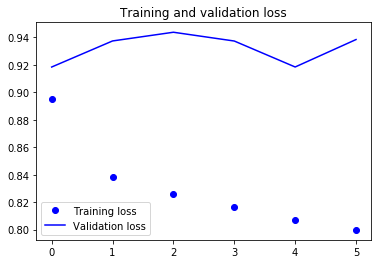

In [320]:
model_tracking.graph_tf_model_history(nn[-1].history)

In [321]:
bits = bits_scorer(nn, X_test, y_test, proba=True)
bits

41.08095445083279

#### Keras classifier based on predictions

In [8]:
N_ROWS = len(data.data)

def create_embed_model(
    n_hidden_layers=0,
    n_cells=50,
    dropout_rate=0.1,
    n_labels=1,
    label_activation='sigmoid',
    loss=bits_loss,
    embed_dim=4,
    **kwargs,
):
    pred_input = layers.Input(shape=(1,), dtype='int32', name='preds')
    
    layer_n = layers.Dense(n_cells, input_shape=(1,), activation='relu')(pred_input)
    dropout_n = layers.Dropout(dropout_rate)(layer_n)
    
    for _ in range(n_hidden_layers - 1):
        layer_n = layers.Dense(n_cells, input_shape=(1,), activation='relu')(dropout_n)
        dropout_n = layers.Dropout(dropout_rate)(layer_n)

    output = layers.Dense(n_labels, activation=label_activation)(dropout_n)

    model = models.Model(
        inputs=pred_input,
        outputs=output,
    )
    model.compile(loss=loss, optimizer='adam')

    return lambda: model

In [9]:
# Keras classifier with prediction input

K.clear_session()

class PredictionEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        self._min_pred = round(X.min())

        return self
    
    def transform(self, X, y=None):
        # Assumes that X is a single prediction column
        X_np = np.array(X).reshape(-1)

        # In case there are negative predicted margins smaller than our training set,
        # we set them to zero
        return np.maximum(X_np.round() - min(self._min_pred, 0), np.zeros(len(X_np))).astype(int).reshape(-1, 1)

nnse = make_pipeline(
    KerasWrapper(
        model_func=create_embed_model,
        n_hidden_layers=1,
        n_cells=25,
        dropout_rate=0.1,
        n_labels=2,
        label_activation='softmax',
        loss=bits_loss,
    ),
)

# nnse[:-1].fit(X_train_se)
# X_val_trans = nnse[:-1].transform(X_val_se)

nnse.fit(
    X_train_se,
    y_train_se,
    keraswrapper__validation_data=(X_val_se, y_val)
)

Train on 16862 samples, validate on 414 samples
Epoch 1/20
16862/16862 [==============================] - 2s 104us/sample - loss: 0.2987 - val_loss: 5.4901
Epoch 2/20
16862/16862 [==============================] - 1s 58us/sample - loss: 0.0185 - val_loss: 6.2853
Epoch 3/20
16862/16862 [==============================] - 1s 57us/sample - loss: 0.0095 - val_loss: 6.8259
Epoch 4/20
16862/16862 [==============================] - 1s 60us/sample - loss: 0.0055 - val_loss: 7.1823
Epoch 5/20
16862/16862 [==============================] - 1s 70us/sample - loss: 0.0033 - val_loss: 7.5908
Epoch 6/20
16862/16862 [==============================] - 1s 60us/sample - loss: 0.0022 - val_loss: 7.8453


Pipeline(memory=None,
         steps=[('keraswrapper',
                 KerasWrapper(dropout_rate=0.1, embed_dim=4,
                              label_activation='softmax',
                              loss=<function bits_loss at 0x7efd218f2440>,
                              model_func=<function create_embed_model at 0x7efd217f0cb0>,
                              n_cells=25, n_hidden_layers=1, n_labels=2))],
         verbose=False)

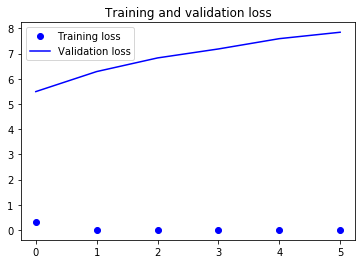

In [10]:
model_tracking.graph_tf_model_history(nnse[-1].history)

In [11]:
bits = bits_scorer(
    nnse,
    X_test_se,
    y_test,
    proba=True,
)
bits

/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2_utils.py:544: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(inputs, collections.Sequence):


-997.8298418244742

#### Conclusion

A basic neural net with the full data set performs about as well as XGBoost. The model that takes `StackingEstimator` predictions as input performs horribly, whether the model uses an embedding layer or not. Given that the results of `predict_proba` tend to be very close to 0 or 1, it probably just way over-fits, resulting in excessive confidence in its predictions.

### Conclusion

Although the default `XGBClassifier` performed best, I believe some tuning would improve the version of `XGBClassifier` with the custom loss function such that it performed better. Same goes for the neural net, but `xgboost` models are simpler and train faster, so I'll stick with them for now, because I don't feel like dealing with optimising NN architectures.